## Functions

In [1]:
import os
import pickle

import pandas as pd
from tqdm import tqdm

import nibabel as nib
import numpy as np

from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_pickle(path):
    with open(path, 'rb') as f:
        pickled = pickle.load(f)
    return pickled
def save_pickle(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

In [3]:
def get_train_test_representations(rep_path):
    layer_representation = np.vstack(load_pickle(rep_path))                
    # Flatten the representation if necessary
    model_representations = layer_representation.reshape(layer_representation.shape[0], -1)
    # print('shape of input', model_representations.shape)
    # Step 1: Create a mapping of video names to their indices
    train_name_idx = load_pickle('../Data/train_idx.pkl')
    test_name_idx = load_pickle('../Data/test_idx.pkl')
    # Step 2: Average the representations for each video
    def average(video_indices):
        averaged_representations = []
        for video, indices in video_indices.items():
            # Extract representations for the current video
            video_reps = model_representations[indices]
            # Compute the average representation
            averaged_rep = np.mean(video_reps, axis=0)
            averaged_representations.append(averaged_rep)
        # Step 3: Convert the list to a numpy array
        averaged_representations = np.array(averaged_representations)  # Shape: (n_videos, n_hidden_dim)
        return averaged_representations
    train_representations = average(train_name_idx)
    test_representations = average(test_name_idx)
    # print('shape of data',train_representations.shape)
    # print('shape of data',test_representations.shape)
    return train_representations, test_representations

In [4]:
def load_roi_mask(roi_mask_path):
    """
    Load a 3D ROI mask using nibabel.
    
    Parameters:
    - roi_mask_path (str): Path to the 3D NIfTI mask file.
    
    Returns:
    - roi_mask (np.array): 3D binary mask indicating the ROI voxels.
    """
    mask_img = nib.load(roi_mask_path)
    roi_mask = mask_img.get_fdata().astype(bool)  # Convert to boolean mask
    return roi_mask

In [5]:
def apply_roi_mask(beta_values, roi_mask):
    """
    Apply the ROI mask to the 4D beta values.
    
    Parameters:
    - beta_values (np.array): 4D array of beta values (n_voxels_x, n_voxels_y, n_voxels_z, n_stimuli)
    - roi_mask (np.array): 3D binary mask indicating the ROI voxels
    
    Returns:
    - beta_values_roi (np.array): 2D array of beta values for the ROI, shape (n_stimuli, n_voxels_in_roi)
    """
    masked_beta_values = beta_values[roi_mask]  # Extract voxels inside the ROI
    n_stimuli = beta_values.shape[-1]
    beta_values_roi = masked_beta_values.reshape(-1, n_stimuli).T  # Shape (n_stimuli, n_voxels_in_roi)
    return beta_values_roi

In [6]:
def find_roi_mask_paths(subj):
    """
    Finds the paths to left and right hemisphere ROI mask files for a given subject.

    Parameters:
    subj (str): The subject identifier, used to construct the path to the subject's ROI mask files.

    Returns:
    roi_mask_paths (list): A list of tuples, where each tuple contains:
        - A string representing the ROI with hemisphere ('_lh' for left hemisphere, '_rh' for right hemisphere).
        - The full file path to the corresponding ROI mask file
    """
    
    roi_mask_paths = []
    subject_path = f'../neural_scans/localizers/{subj}'
    
    # Loop through the ROIs defined globally in the variable 'rois'
    for roi in ROIS:
        for roi_mask_file_name in os.listdir(subject_path):
            # Check if the file name contains the current ROI and ends with '.nii.gz'
            if 'roi-'+roi in roi_mask_file_name and roi_mask_file_name.endswith('.nii.gz'):
                if 'hemi-lh' in roi_mask_file_name:
                    roi_mask_paths.append((roi+'_lh', os.path.join(subject_path, roi_mask_file_name)))
                elif 'hemi-rh' in roi_mask_file_name:
                    roi_mask_paths.append((roi+'_rh', os.path.join(subject_path, roi_mask_file_name)))
                else:
                    print(f'Unrecognized ROI mask file name: {roi}')
    return roi_mask_paths

In [7]:
def z_score_normalize(train_data, test_data):
    """
    Normalize train and test data using z-score normalization.
    
    Parameters:
    train_data (np.array): Training data to be normalized
    test_data (np.array): Test data to be normalized using train data parameters
    
    Returns:
    tuple: Normalized train_data and test_data
    """
    if train_data.ndim == 1:
        train_data = train_data.reshape(-1, 1)
        test_data = test_data.reshape(-1, 1)
    scaler = StandardScaler()
    normalized_train_data = scaler.fit_transform(train_data)
    normalized_test_data = scaler.transform(test_data)
    if normalized_train_data.shape[1] == 1:
        normalized_train_data = normalized_train_data.flatten()
        normalized_test_data = normalized_test_data.flatten()
    return normalized_train_data, normalized_test_data

In [8]:
def get_train_idx():
    ## Exclude the train neural scans of excluded train videos
    actural_names = list(load_pickle('../Data/train_idx.pkl').keys())
    train_video_names = pd.read_csv('../Data/train.csv')['video_name']
    train_idx = []
    for i, name in enumerate(train_video_names):
        if name not in actural_names:
            print(f'{i}th video: {name} is excluded')
        else:
            train_idx.append(i)
    len(train_idx)
    return train_idx

In [9]:
def preprocess_voxels(f_train_idx):
    # SUBJECT LEVEL LOOP
    total_voxels = 0
    for subj_id in SUBJ_IDS:
        fmri_train_path = f'../neural_scans/betas/{subj_id}/{subj_id}_space-T1w_desc-train-fracridge_data.nii.gz'
        # load only the train data: shape np (x, y, z, n_stimuli=200)
        y_train_subj = nib.load(fmri_train_path).get_fdata()
        # Exclude the sample correspond to the excluded video
        y_train_subj = y_train_subj[:,:,:,f_train_idx]
        # Finds the paths to lh rh ROI mask files
        roi_mask_paths = find_roi_mask_paths(subj_id) 
        # ROI LEVEL LOOP
        for roi, roi_mask_path in tqdm(roi_mask_paths): 
            # Get the roi_mask: shape np (x, y, z)
            roi_mask = load_roi_mask(roi_mask_path)
            # Get the beta values inside the ROI, shape: np (n_stimuli, n_voxels_in_roi)
            y_train_roi = apply_roi_mask(y_train_subj, roi_mask)
            n_voxels_in_roi = y_train_roi.shape[1]
            nan_voxel = 0
            # VOXEL LEVEL LOOP
            for voxel_idx in range(n_voxels_in_roi):
                # Get the beta values for a specific voxel, shape np (n_stimuli=199,)
                y_train_voxel = y_train_roi[:, voxel_idx]
                # Check for NaN values and skip this voxel if any NaNs are present
                if np.isnan(y_train_voxel).any():
                    nan_voxel += 1
                    continue
                # Z-score normalization
                y_train_voxel = (y_train_voxel - np.mean(y_train_voxel)) / np.std(y_train_voxel)
                neural_save_path = f'../betas_organized/{subj_id}/{roi}'
                os.makedirs(neural_save_path, exist_ok=True)
                neural_save_path = os.path.join(neural_save_path, f'{voxel_idx}.pkl')
                save_pickle(y_train_voxel, neural_save_path)  
                total_voxels += 1
    return total_voxels

In [10]:
def encoding(f_total_voxels):
    iterations = len(MODEL_SELECTIONS) * 20 * f_total_voxels
    alphas = np.logspace(-2, 5, 7)
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    
    with tqdm(total=iterations) as pbar:
        # MODEL CLASS LEVEL LOOP
        for i, model_class in enumerate(MODEL_SELECTIONS):
            trained_model_path = os.path.join(MODEL_PATH[i], model_class)
            # MODEL LEVEL LOOP
            for model_name in os.listdir(trained_model_path):
                model_path = os.path.join(trained_model_path, model_name, f'{LAYER_SELECTIONS[i]}.pkl')
                # Get the model layer representations, ie X, shape (n_stimulus, n_hidden_dims)
                X_train_layer, _ = get_train_test_representations(model_path)
                X_train_layer, _ = z_score_normalize(X_train_layer, _)
                # SUBJ LEVEL LOOP
                for subj_id in SUBJ_IDS:
                    beta_subj_path = f'../betas_organized/{subj_id}'
                    # ROI LEVEL LOOP
                    for roi in os.listdir(beta_subj_path):
                        beta_roi_path = os.path.join(beta_subj_path, roi)
                        # Path to the encoding score of the current ROI
                        roi_output_path = os.path.join(OUTPUT_PATH[i], model_class, LAYER_SELECTIONS[i], model_name, subj_id)
                        os.makedirs(roi_output_path, exist_ok=True)
                        roi_output_path = os.path.join(roi_output_path, f"{roi}_results.pkl")
                        # If the current ROI has been encoded, skip
                        if not RESTART and os.path.exists(roi_output_path):
                            pbar.update(len(os.listdir(beta_roi_path)))
                            continue
                        # Else, encode each voxel in this ROI
                        # VOXEL LEVEL LOOP
                        average_scores = []
                        voxel_file_names = []
                        for voxel in os.listdir(beta_roi_path):
                            voxel_path = os.path.join(beta_roi_path, voxel)
                            # Get the beta values for a specific voxel, shape np (n_stimuli=199,)
                            y_train_voxel = load_pickle(voxel_path)
                            fold_scores = []
                            # CV LEVEL LOOP
                            for fold_train_idx, fold_val_idx in kf.split(X_train_layer):
                                # Split into train and validation
                                X_train_fold, X_val_fold = X_train_layer[fold_train_idx], X_train_layer[fold_val_idx]
                                y_train_fold, y_val_fold = y_train_voxel[fold_train_idx], y_train_voxel[fold_val_idx]
                
                                ridge = RidgeCV(alphas=alphas, store_cv_results=True)
                                ridge.fit(X_train_fold, y_train_fold)
                                y_val_pred = ridge.predict(X_val_fold)
                                val_score = pearsonr(y_val_pred, y_val_fold)[0]
                                fold_scores.append(val_score)
                            average_scores.append(np.mean(fold_scores))
                            voxel_file_names.append(voxel)
                            pbar.update(1)
                        roi_result = {
                            'Voxel': voxel_file_names,
                            'Average Correlation': average_scores
                        }
                        save_pickle(roi_result, roi_output_path)         

LOOP STRUCTURE
- model calss & layers
- pretrained models
- subject
- ROI
- voxel
- fold cross validation


In [11]:
def plot_mapping_results(df, out_file=None, size=(15, 5), label_fontsize=14, tick_fontsize=12, dodge = 0.55):
    _, axes = plt.subplots(1, 2, figsize=size, gridspec_kw={'width_ratios': [3, 1]},
                           sharey=True)
    sns.set_palette("flare")
    for i_ax, (ax, cur_rois) in enumerate(zip(axes,
                                              [['EVC_lh', 'EVC_rh', 'MT_lh', 'MT_rh', 'EBA_lh', 'EBA_rh', 'LOC_lh', 'LOC_rh', 'pSTS_lh', 'pSTS_rh', 'aSTS_lh', 'aSTS_rh'],
                                               ['FFA_lh', 'FFA_rh', 'PPA_lh', 'PPA_rh']])):

        legend = True if i_ax == 1 else False
        cur_scores = df[df.ROI.isin(cur_rois)].copy()
        cur_scores['ROI'] = pd.Categorical(
            cur_scores['ROI'],
            categories=cur_rois, 
            ordered=True
        )
        sns.stripplot(x='ROI', y='test_score', hue='model_class', data=cur_scores,
                      ax=ax, dodge=True, jitter=True, linewidth=.5,
                      alpha=0.25, zorder=0, legend=False)
        strip_collections = ax.collections
        sns.pointplot(x='ROI', y='test_score', hue='model_class',
                      data=cur_scores, legend=legend,
                          ax=ax, dodge=dodge, linestyle="none", errorbar=('ci', 95),
                      marker="_", markersize=14, markeredgewidth=3, zorder=1)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('', fontsize=label_fontsize)
        ax.set_ylim([-0.05, 0.3])
        ax.tick_params(axis='x', labelsize=tick_fontsize)  # Set x-tick label size
        ax.tick_params(axis='y', labelsize=tick_fontsize)  # Set y-tick label size

        if i_ax == 0: 
            ax.set_ylabel('score ($r$)', fontsize=label_fontsize)
        else:
            ax.legend(loc='center right', bbox_to_anchor=(1.7, .5),
                      ncol=1, fancybox=True)

    if out_file is not None:
        plt.savefig(f'../result_figures/neural_encoding/{out_file}.png', bbox_inches='tight')

In [12]:
def change_name(model_class_name, pc):
    if model_class_name == 'SocialGNN_V':
        return f'SocialGNN_{pc}'
    elif model_class_name == 'CueBasedLSTM':
        return f'LSTM_{pc}'
    elif model_class_name == 'CueBasedLSTM-Relation':
        return f'LSTMrel_{pc}'
    elif model_class_name == 'LSTM_only_edge':
        return 'LSTM_rem'
    elif 'SocialGNN_randomize_node' in model_class_name:
        return f'GNN_rand_{pc}'
    elif 'SocialGNN_zero_node' in model_class_name:
        return f'GNN_zero_{pc}'
    else:
        raise ValueError(f'Unrecognized model class name: {model_class_name}')
    
    
def plot_results(image_name=None, size=(15, 5), label_fontsize=14, tick_fontsize=11, dodge=0.55):
    all_scores = {
        'model_name': [],
        'model_class': [],
        'test_score': [],
        'ROI': [],
        'layer': []
    }
    for i, model_class in enumerate(MODEL_SELECTIONS):
        trained_model_path = os.path.join(OUTPUT_PATH[i], model_class, LAYER_SELECTIONS[i])
        for model_name in os.listdir(trained_model_path):
            model_path = os.path.join(trained_model_path, model_name)
            ROI_score = {
                'aSTS_lh': [], 'aSTS_rh': [],
                'pSTS_lh': [], 'pSTS_rh': [],
                'EBA_lh': [], 'EBA_rh': [],
                'EVC_lh': [], 'EVC_rh': [],
                'FFA_lh': [], 'FFA_rh': [],
                'LOC_lh': [], 'LOC_rh': [],
                'MT_lh': [], 'MT_rh': [],
                'PPA_lh': [], 'PPA_rh': []
            }
            
            for subject_id in os.listdir(model_path):
                subject_id_path = os.path.join(model_path, subject_id)
                for roi in os.listdir(subject_id_path):
                    roi_path = os.path.join(subject_id_path, roi)
                    roi = roi.replace('_results.pkl', '')
                    ROI_score[roi].extend(load_pickle(roi_path)['Average Correlation'])
            plot_name_model_class = change_name(model_class, PCS[i])
            all_scores['model_name'].extend([model_name for _ in range(16)])
            all_scores['model_class'].extend([plot_name_model_class for _ in range(16)])
            
            for key, val in ROI_score.items():
                all_scores['test_score'].append(np.mean(np.array(val)))
                all_scores['ROI'].append(key)
                
            all_scores['layer'].extend([LAYER_SELECTIONS[i] for _ in range(16)])
        
    all_scores = pd.DataFrame(all_scores)
    plot_mapping_results(df=all_scores, out_file=image_name, size=size, label_fontsize=label_fontsize, tick_fontsize=tick_fontsize, dodge=dodge)

    # Call the function to print significant pairs
    print_significant_pairs(all_scores)

def print_significant_pairs(df):
    def significance_stars(p_value):
        """Return the number of stars for significance level."""
        if p_value < 0.001:
            return '***'  # 3 stars for p < 0.001
        elif p_value < 0.01:
            return '**'   # 2 stars for p < 0.01
        elif p_value < 0.05:
            return '*'    # 1 star for p < 0.05
        else:
            return ''     # No stars for non-significant results

    # Group by ROI
    rois = df['ROI'].unique()
    
    # Print header
    print(f"\n{'ROI':<13} {'Model A':<10} {'Model B':<10} {'p-value':<10} {'Significance':<15}")
    print("=" * 80)

    for roi in rois:
        # Get test scores for the current ROI
        roi_data = df[df['ROI'] == roi]
        model_class = roi_data['model_class'].unique()
        
        # Create a DataFrame to hold scores for statistical testing
        scores = {}
        for model_name in model_class:
            model_scores = roi_data[roi_data['model_class'] == model_name]['test_score'].values
            scores[model_name] = model_scores
            
        # Perform paired t-tests between models
        for i in range(len(model_class)):
            for j in range(i + 1, len(model_class)):
                model_a = model_class[i]
                model_b = model_class[j]
                
                # if model_a in scores and model_b in scores:
                stat, p_value = stats.ttest_rel(scores[model_a], scores[model_b])
                stars = significance_stars(p_value)
                
                # Print significant results
                # if stars:
                print(f"{roi:<13} {model_a:<10} {model_b:<10} {p_value:<10.4f} {stars:<15}")
        print("-" * 80)

## Encoding

In [13]:
OUTPUT_DIM = 2
RESTART = False
ROIS = ['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS', 'FFA', 'PPA']
SUBJ_IDS = ['sub-01', 'sub-02', 'sub-03', 'sub-04']

In [14]:
## EDIT this before run
PC_NUM = 90
# the order of model selections should correspond to layer selection and parameter selections!!
MODEL_SELECTIONS = ['CueBasedLSTM', 'SocialGNN_V', 'CueBasedLSTM-Relation']
PCS = [PC_NUM for _ in range(len(MODEL_SELECTIONS))]
LAYER_SELECTIONS = ['final_state', 'final_state', 'final_state']
OUTPUT_PATH = [f'../neural_encoding_outputs/PC{PC_NUM}/' for _ in range(len(MODEL_SELECTIONS))]
MODEL_PATH = [f'../layer_representations/PC{PC_NUM}/' for _ in range(len(MODEL_SELECTIONS))]

In [15]:
# encoding(preprocess_voxels(get_train_idx()))


ROI           Model A    Model B    p-value    Significance   
aSTS_lh       LSTM_90    SocialGNN_90 0.1010                    
aSTS_lh       LSTM_90    LSTMrel_90 0.3061                    
aSTS_lh       SocialGNN_90 LSTMrel_90 0.0223     *              
--------------------------------------------------------------------------------
aSTS_rh       LSTM_90    SocialGNN_90 0.0129     *              
aSTS_rh       LSTM_90    LSTMrel_90 0.4431                    
aSTS_rh       SocialGNN_90 LSTMrel_90 0.0024     **             
--------------------------------------------------------------------------------
pSTS_lh       LSTM_90    SocialGNN_90 0.0032     **             
pSTS_lh       LSTM_90    LSTMrel_90 0.0431     *              
pSTS_lh       SocialGNN_90 LSTMrel_90 0.0001     ***            
--------------------------------------------------------------------------------
pSTS_rh       LSTM_90    SocialGNN_90 0.0525                    
pSTS_rh       LSTM_90    LSTMrel_90 0.3760       

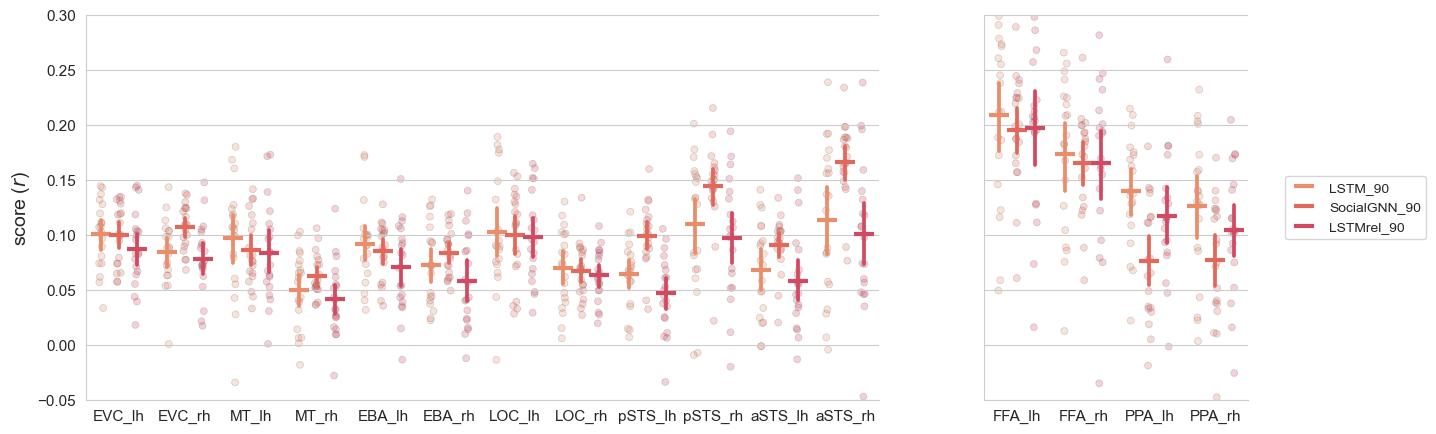

In [16]:
plot_results(image_name = f'PC{PC_NUM}')

In [17]:
## EDIT this before run
PC_NUM = 20
# the order of model selections should correspond to layer selection and parameter selections!!
MODEL_SELECTIONS = ['CueBasedLSTM', 'SocialGNN_V', 'CueBasedLSTM-Relation']
PCS = [PC_NUM for _ in range(len(MODEL_SELECTIONS))]
LAYER_SELECTIONS = ['final_state', 'final_state', 'final_state']
OUTPUT_PATH = [f'../neural_encoding_outputs/PC{PC_NUM}/' for _ in range(len(MODEL_SELECTIONS))]
MODEL_PATH = [f'../layer_representations/PC{PC_NUM}/' for _ in range(len(MODEL_SELECTIONS))]


ROI           Model A    Model B    p-value    Significance   
aSTS_lh       LSTM_20    SocialGNN_20 0.3048                    
aSTS_lh       LSTM_20    LSTMrel_20 0.8840                    
aSTS_lh       SocialGNN_20 LSTMrel_20 0.3998                    
--------------------------------------------------------------------------------
aSTS_rh       LSTM_20    SocialGNN_20 0.0067     **             
aSTS_rh       LSTM_20    LSTMrel_20 0.5636                    
aSTS_rh       SocialGNN_20 LSTMrel_20 0.0308     *              
--------------------------------------------------------------------------------
pSTS_lh       LSTM_20    SocialGNN_20 0.0032     **             
pSTS_lh       LSTM_20    LSTMrel_20 0.5792                    
pSTS_lh       SocialGNN_20 LSTMrel_20 0.0140     *              
--------------------------------------------------------------------------------
pSTS_rh       LSTM_20    SocialGNN_20 0.0075     **             
pSTS_rh       LSTM_20    LSTMrel_20 0.4370       

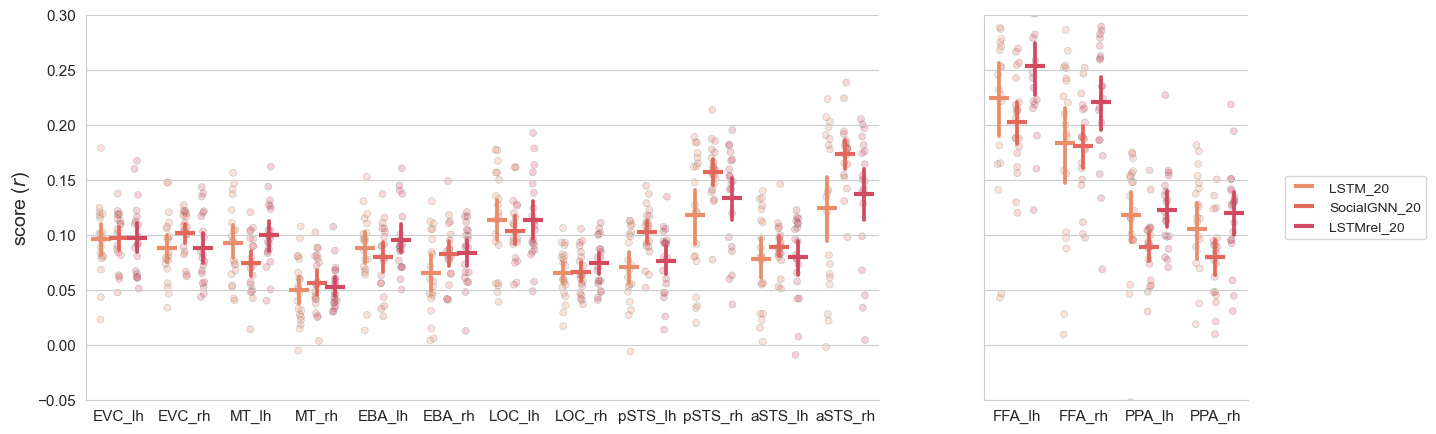

In [18]:
plot_results(image_name = f'PC{PC_NUM}')

## Only Edge Models

In [19]:
# the order of model selections should correspond to layer selection and parameter selections!!
PC_NUM = 90
MODEL_SELECTIONS = ['LSTM_only_edge', f'SocialGNN_randomize_node_PC{PC_NUM}', f'SocialGNN_zero_node_PC{PC_NUM}']
LAYER_SELECTIONS = ['final_state', 'final_state', 'final_state']
PCS = [PC_NUM for _ in range(len(MODEL_SELECTIONS))]
OUTPUT_PATH = ['../neural_encoding_outputs/only_edge_models/' for _ in range(len(MODEL_SELECTIONS))]
MODEL_PATH = ['../layer_representations/only_edge_models/' for _ in range(len(MODEL_SELECTIONS))]

In [20]:
# encoding(preprocess_voxels(get_train_idx()))


ROI           Model A    Model B    p-value    Significance   
aSTS_lh       LSTM_rem   GNN_rand_90 0.0000     ***            
aSTS_lh       LSTM_rem   GNN_zero_90 0.0109     *              
aSTS_lh       GNN_rand_90 GNN_zero_90 0.0010     **             
--------------------------------------------------------------------------------
aSTS_rh       LSTM_rem   GNN_rand_90 0.0000     ***            
aSTS_rh       LSTM_rem   GNN_zero_90 0.0068     **             
aSTS_rh       GNN_rand_90 GNN_zero_90 0.0012     **             
--------------------------------------------------------------------------------
pSTS_lh       LSTM_rem   GNN_rand_90 0.0000     ***            
pSTS_lh       LSTM_rem   GNN_zero_90 0.0083     **             
pSTS_lh       GNN_rand_90 GNN_zero_90 0.0000     ***            
--------------------------------------------------------------------------------
pSTS_rh       LSTM_rem   GNN_rand_90 0.0000     ***            
pSTS_rh       LSTM_rem   GNN_zero_90 0.0093     **

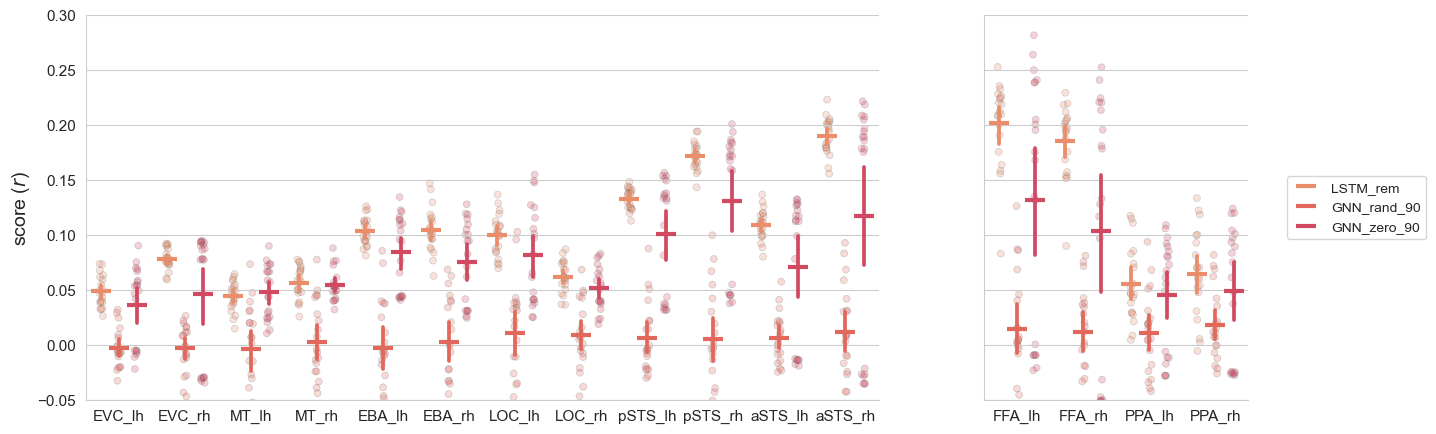

In [21]:
plot_results()


ROI           Model A    Model B    p-value    Significance   
aSTS_lh       LSTM_rem   GNN_rand_20 0.0000     ***            
aSTS_lh       LSTM_rem   GNN_zero_20 0.1191                    
aSTS_lh       GNN_rand_20 GNN_zero_20 0.0000     ***            
--------------------------------------------------------------------------------
aSTS_rh       LSTM_rem   GNN_rand_20 0.0000     ***            
aSTS_rh       LSTM_rem   GNN_zero_20 0.0933                    
aSTS_rh       GNN_rand_20 GNN_zero_20 0.0000     ***            
--------------------------------------------------------------------------------
pSTS_lh       LSTM_rem   GNN_rand_20 0.0000     ***            
pSTS_lh       LSTM_rem   GNN_zero_20 0.1745                    
pSTS_lh       GNN_rand_20 GNN_zero_20 0.0000     ***            
--------------------------------------------------------------------------------
pSTS_rh       LSTM_rem   GNN_rand_20 0.0000     ***            
pSTS_rh       LSTM_rem   GNN_zero_20 0.1184       

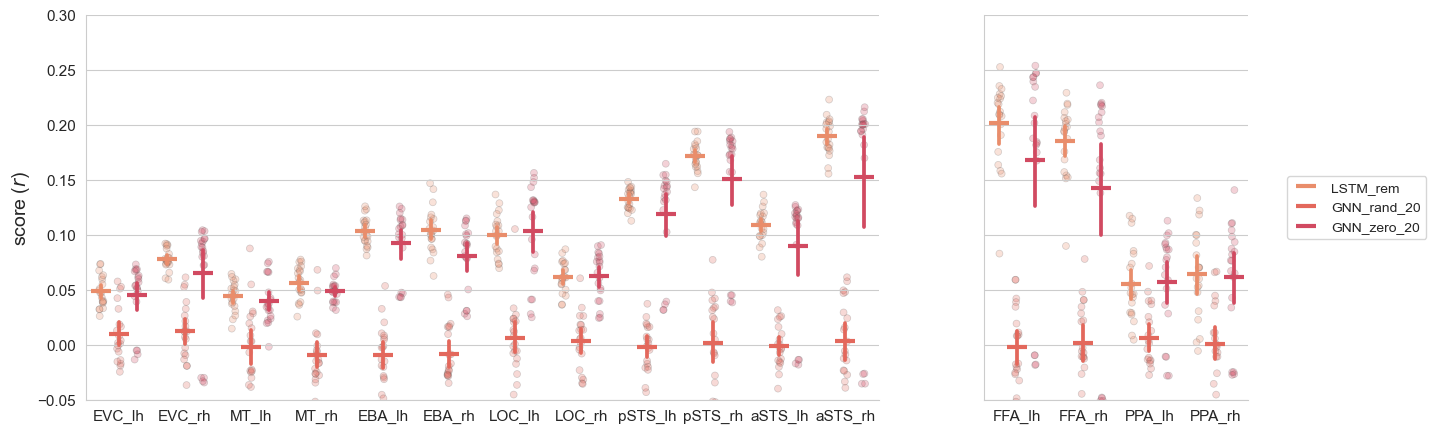

In [22]:
PC_NUM = 20
MODEL_SELECTIONS = ['LSTM_only_edge', f'SocialGNN_randomize_node_PC{PC_NUM}', f'SocialGNN_zero_node_PC{PC_NUM}']
LAYER_SELECTIONS = ['final_state', 'final_state', 'final_state']
PCS = [PC_NUM for _ in range(len(MODEL_SELECTIONS))]
OUTPUT_PATH = ['../neural_encoding_outputs/only_edge_models/' for _ in range(len(MODEL_SELECTIONS))]
MODEL_PATH = ['../layer_representations/only_edge_models/' for _ in range(len(MODEL_SELECTIONS))]
plot_results()

## All model plot


ROI           Model A    Model B    p-value    Significance   
aSTS_lh       LSTM_90    SocialGNN_90 0.1010                    
aSTS_lh       LSTM_90    LSTMrel_90 0.3061                    
aSTS_lh       LSTM_90    LSTM_rem   0.0008     ***            
aSTS_lh       LSTM_90    GNN_rand_90 0.0000     ***            
aSTS_lh       LSTM_90    GNN_zero_90 0.8895                    
aSTS_lh       SocialGNN_90 LSTMrel_90 0.0223     *              
aSTS_lh       SocialGNN_90 LSTM_rem   0.0145     *              
aSTS_lh       SocialGNN_90 GNN_rand_90 0.0000     ***            
aSTS_lh       SocialGNN_90 GNN_zero_90 0.2263                    
aSTS_lh       LSTMrel_90 LSTM_rem   0.0000     ***            
aSTS_lh       LSTMrel_90 GNN_rand_90 0.0003     ***            
aSTS_lh       LSTMrel_90 GNN_zero_90 0.4235                    
aSTS_lh       LSTM_rem   GNN_rand_90 0.0000     ***            
aSTS_lh       LSTM_rem   GNN_zero_90 0.0109     *              
aSTS_lh       GNN_rand_90 GNN_zero_9

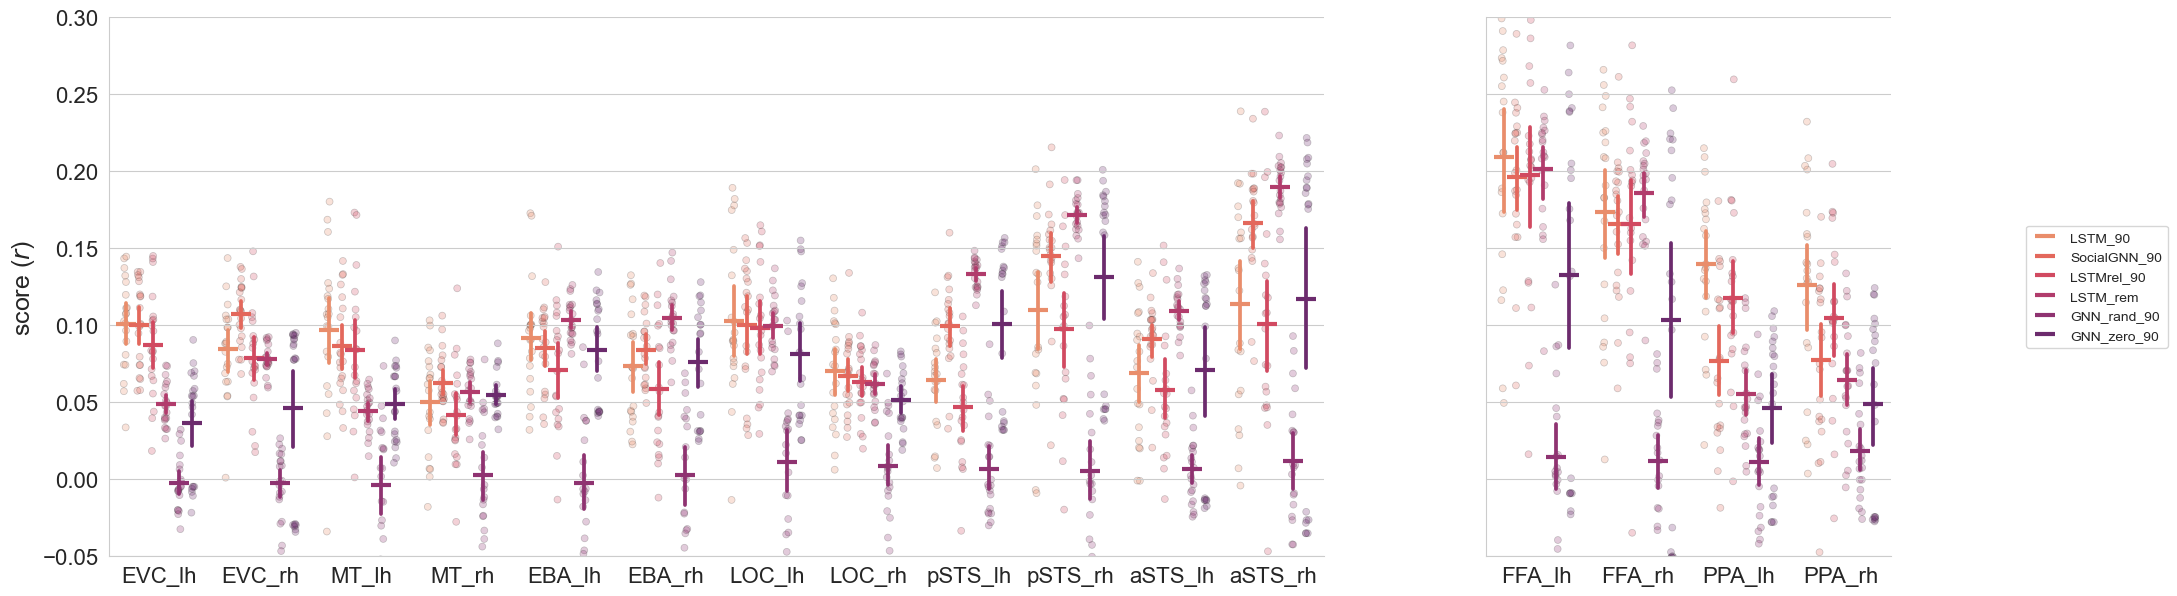

In [23]:
PC_NUM = 90
MODEL_SELECTIONS =  ['CueBasedLSTM', 'SocialGNN_V', 'CueBasedLSTM-Relation', 
                     'LSTM_only_edge', f'SocialGNN_randomize_node_PC{PC_NUM}', f'SocialGNN_zero_node_PC{PC_NUM}']
LAYER_SELECTIONS = ['final_state', 'final_state', 'final_state', 'final_state', 'final_state', 'final_state']
PCS = [PC_NUM for _ in range(len(MODEL_SELECTIONS))]
OUTPUT_PATH = [ f'../neural_encoding_outputs/PC{PC_NUM}/' for _ in range(3)] + ['../neural_encoding_outputs/only_edge_models/' for _ in range(3)]
plot_results(image_name=f'PC{PC_NUM}_all_models', size=(23, 7), label_fontsize=18, tick_fontsize=16, dodge = 0.65)



ROI           Model A    Model B    p-value    Significance   
aSTS_lh       LSTM_20    SocialGNN_20 0.3048                    
aSTS_lh       LSTM_20    LSTMrel_20 0.8840                    
aSTS_lh       LSTM_20    LSTM_rem   0.0127     *              
aSTS_lh       LSTM_20    GNN_rand_20 0.0000     ***            
aSTS_lh       LSTM_20    GNN_zero_20 0.5295                    
aSTS_lh       SocialGNN_20 LSTMrel_20 0.3998                    
aSTS_lh       SocialGNN_20 LSTM_rem   0.0017     **             
aSTS_lh       SocialGNN_20 GNN_rand_20 0.0000     ***            
aSTS_lh       SocialGNN_20 GNN_zero_20 0.9493                    
aSTS_lh       LSTMrel_20 LSTM_rem   0.0025     **             
aSTS_lh       LSTMrel_20 GNN_rand_20 0.0000     ***            
aSTS_lh       LSTMrel_20 GNN_zero_20 0.5098                    
aSTS_lh       LSTM_rem   GNN_rand_20 0.0000     ***            
aSTS_lh       LSTM_rem   GNN_zero_20 0.1191                    
aSTS_lh       GNN_rand_20 GNN_zero_2

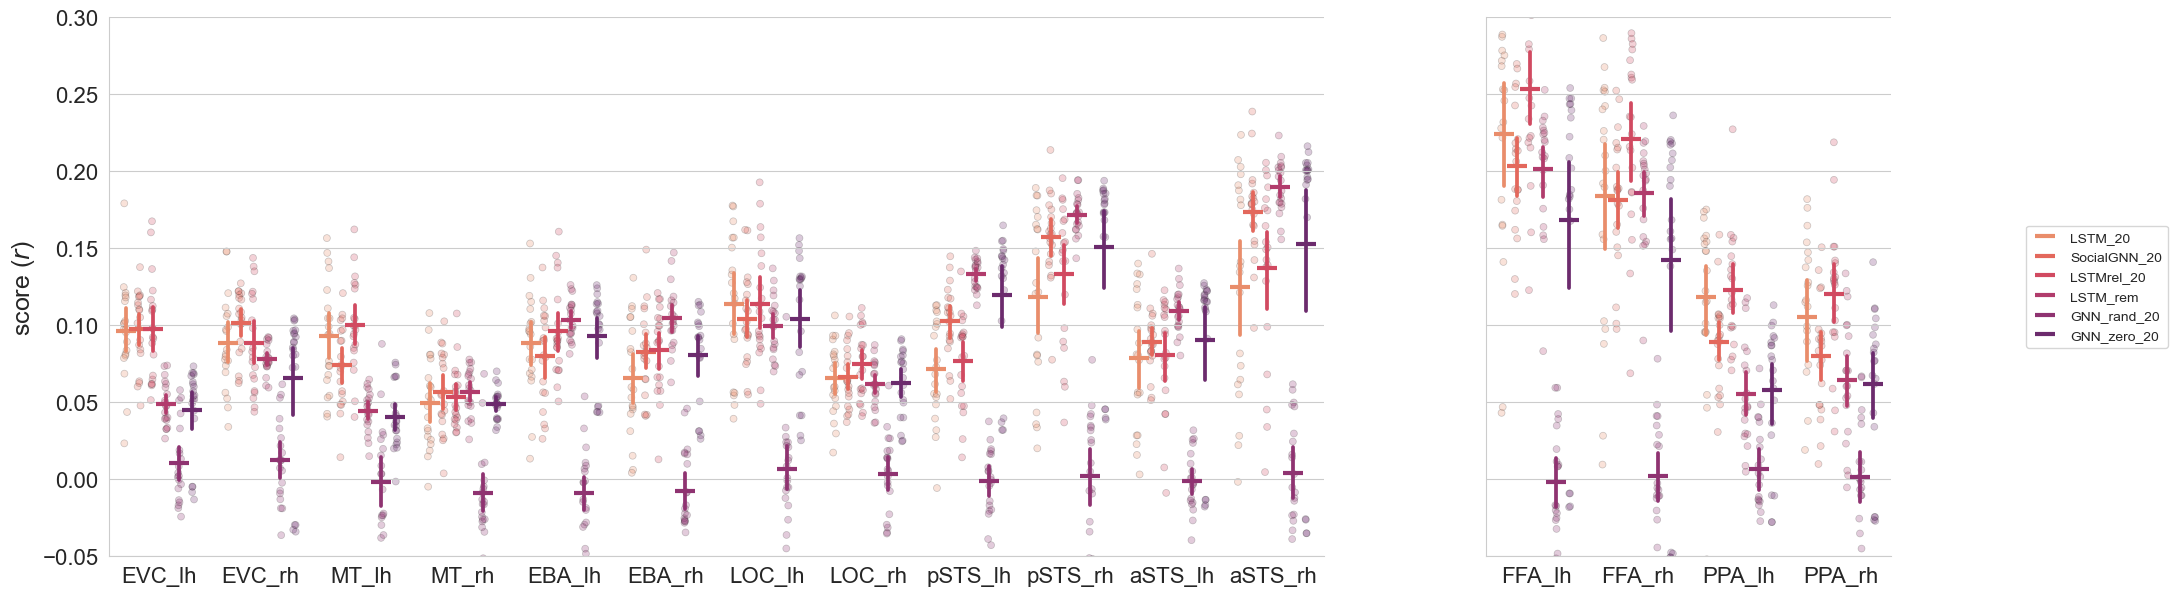

In [24]:
PC_NUM = 20
MODEL_SELECTIONS =  ['CueBasedLSTM', 'SocialGNN_V', 'CueBasedLSTM-Relation', 
                     'LSTM_only_edge', f'SocialGNN_randomize_node_PC{PC_NUM}', f'SocialGNN_zero_node_PC{PC_NUM}']
PCS = [PC_NUM for _ in range(len(MODEL_SELECTIONS))]
LAYER_SELECTIONS = ['final_state', 'final_state', 'final_state', 'final_state', 'final_state', 'final_state']
OUTPUT_PATH = [ f'../neural_encoding_outputs/PC{PC_NUM}/' for _ in range(3)] + ['../neural_encoding_outputs/only_edge_models/' for _ in range(3)]
plot_results(image_name=f'PC{PC_NUM}_all_models', size=(23, 7), label_fontsize=18, tick_fontsize=16, dodge = 0.65)

## Comparing PC


ROI           Model A    Model B    p-value    Significance   
aSTS_lh       SocialGNN_20 SocialGNN_90 0.7603                    
--------------------------------------------------------------------------------
aSTS_rh       SocialGNN_20 SocialGNN_90 0.3194                    
--------------------------------------------------------------------------------
pSTS_lh       SocialGNN_20 SocialGNN_90 0.6890                    
--------------------------------------------------------------------------------
pSTS_rh       SocialGNN_20 SocialGNN_90 0.0669                    
--------------------------------------------------------------------------------
EBA_lh        SocialGNN_20 SocialGNN_90 0.5496                    
--------------------------------------------------------------------------------
EBA_rh        SocialGNN_20 SocialGNN_90 0.8730                    
--------------------------------------------------------------------------------
EVC_lh        SocialGNN_20 SocialGNN_90 0.7689  

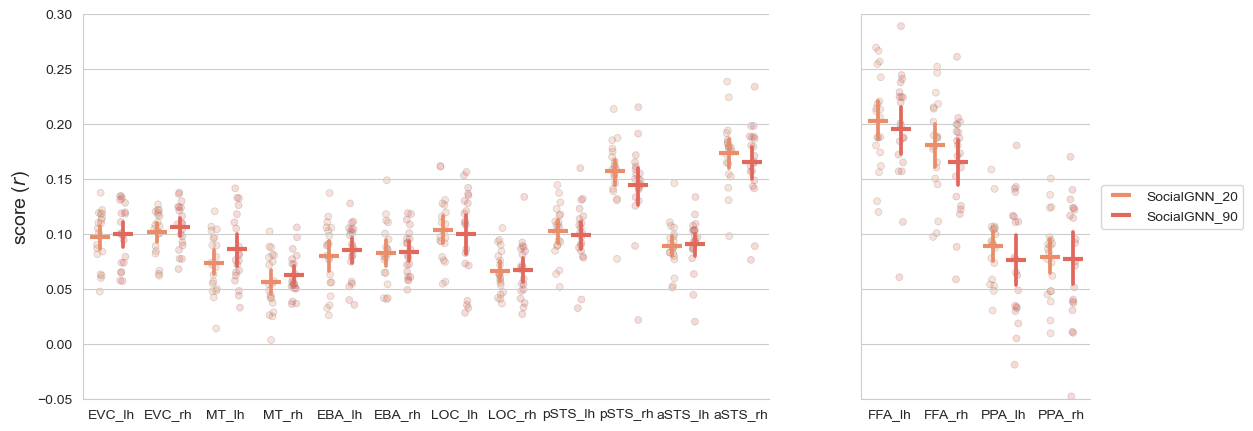

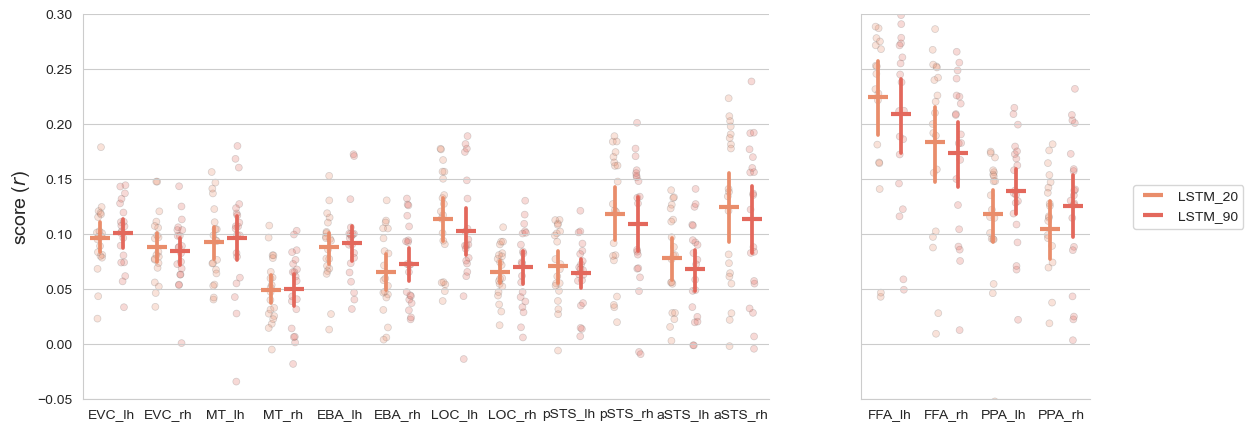

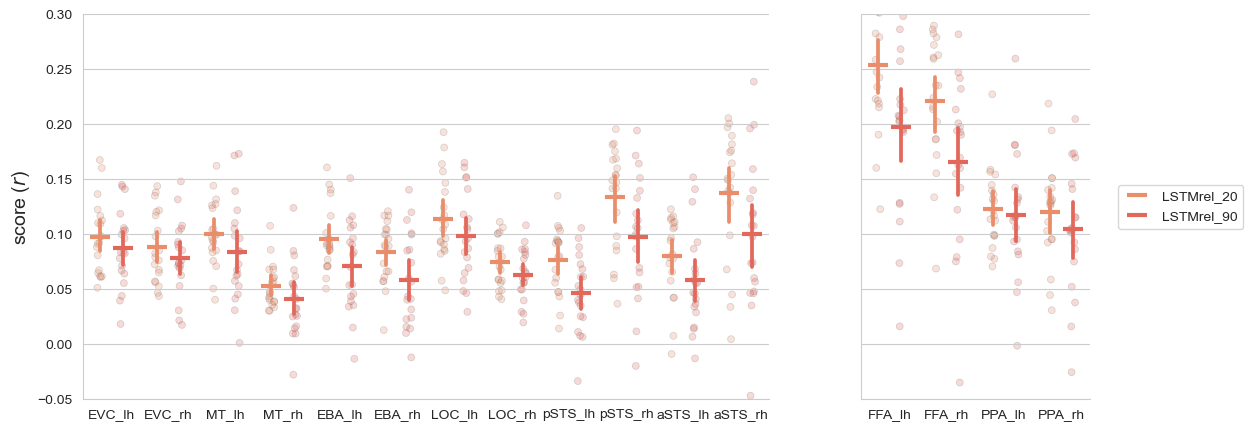

In [25]:
all_model_selections = [
    ['SocialGNN_V', 'SocialGNN_V'],
    ['CueBasedLSTM', 'CueBasedLSTM'],
    ['CueBasedLSTM-Relation', 'CueBasedLSTM-Relation']
]
for test in all_model_selections:
    MODEL_SELECTIONS = test
    PCS = [20, 90]
    LAYER_SELECTIONS = ['final_state' for _ in range(len(MODEL_SELECTIONS))]
    OUTPUT_PATH = [f'../neural_encoding_outputs/PC{PCS[i]}/' for i in range(len(MODEL_SELECTIONS))]
    
    plot_results(image_name=f'PC20vsPC90_{MODEL_SELECTIONS[0]}', size=(13, 5), label_fontsize=14, tick_fontsize=10, dodge = 0.4)


ROI           Model A    Model B    p-value    Significance   
aSTS_lh       GNN_rand_20 GNN_rand_90 0.2395                    
--------------------------------------------------------------------------------
aSTS_rh       GNN_rand_20 GNN_rand_90 0.4997                    
--------------------------------------------------------------------------------
pSTS_lh       GNN_rand_20 GNN_rand_90 0.3867                    
--------------------------------------------------------------------------------
pSTS_rh       GNN_rand_20 GNN_rand_90 0.7881                    
--------------------------------------------------------------------------------
EBA_lh        GNN_rand_20 GNN_rand_90 0.5481                    
--------------------------------------------------------------------------------
EBA_rh        GNN_rand_20 GNN_rand_90 0.3707                    
--------------------------------------------------------------------------------
EVC_lh        GNN_rand_20 GNN_rand_90 0.0350     *          

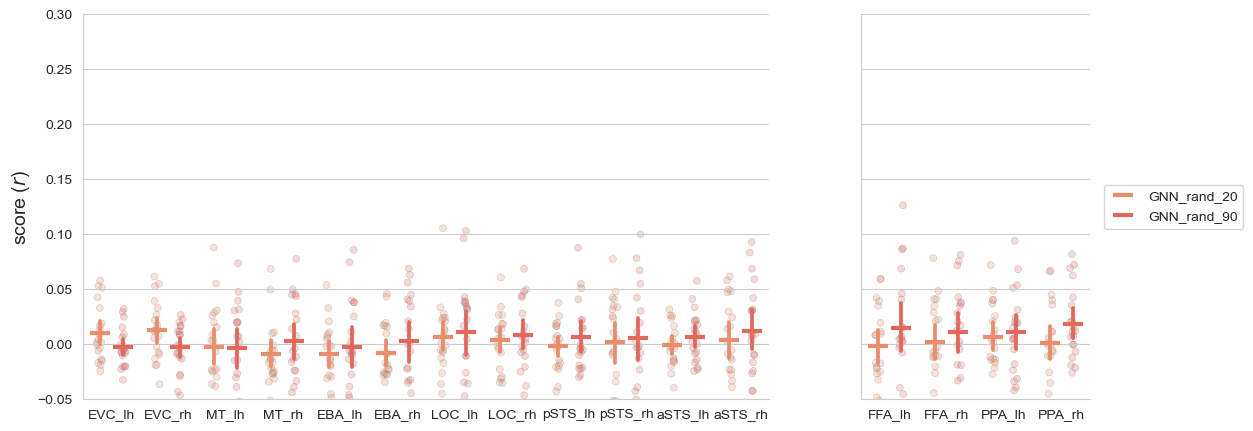

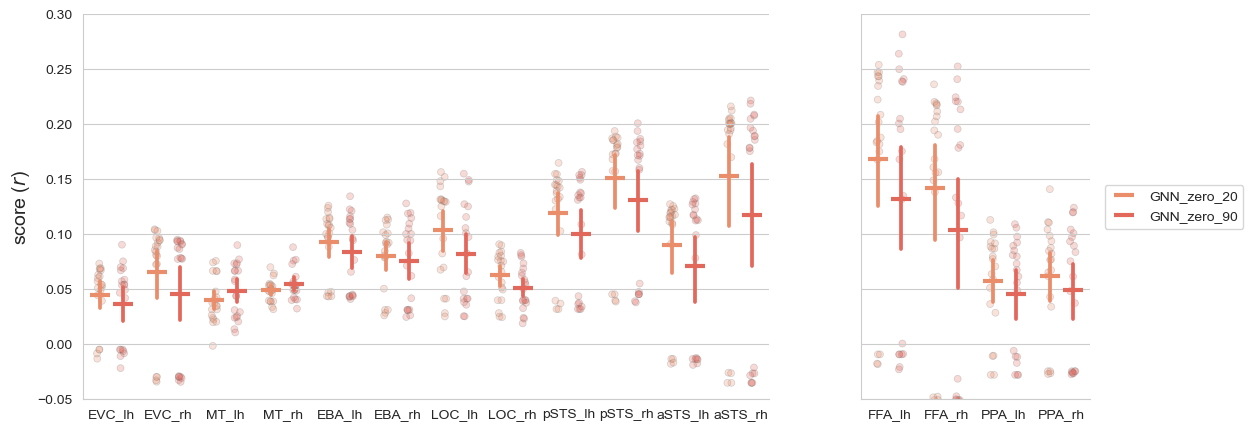

In [26]:
all_model_selections = [[f'SocialGNN_randomize_node_PC20', f'SocialGNN_randomize_node_PC90'],
                        [f'SocialGNN_zero_node_PC20', f'SocialGNN_zero_node_PC90']]
for test in all_model_selections:
    MODEL_SELECTIONS = test
    PCS = [20, 90]
    LAYER_SELECTIONS = ['final_state' for _ in range(len(MODEL_SELECTIONS))]
    OUTPUT_PATH = [f'../neural_encoding_outputs/only_edge_models/' for _ in range(len(MODEL_SELECTIONS))]
    
    plot_results(image_name=f'PC20vsPC90_{MODEL_SELECTIONS[0]}', size=(13, 5), label_fontsize=14, tick_fontsize=10, dodge = 0.4)